</style>
<h1  style="text-align:center;font-size:70px">
    Challenge IOT
    <h2 style="text-align:center">
    The Geolocation Challenge
    </h2>
    <br><br>
    <h2 style="text-align:left;font-size:20px">
      <u>  Team Member : </u>
          <h3 style="text-align:left;font-size:15px">
              <blockquote>
              Sarra <br>
              Mickael Lopes  </blockquote>
          </h3>
     </h2>
</h1>

# Challenge Report

## Introduction 

The challenge is a network based location challenge based on RSSI (Received Signal Strength Indicator). 

A device send several messages at a given time to the nearest stations. Those stations records the message, with the associated signal strength, time of messages and other information.

Based on all the indications, the goal is to predict the location of the device

## Goals

The Algorithm need to show the following : 
- Build feature matrix
- Build ground truth
- Plot error cumulative probability
- Compute prediction criterion: _error @ 80%_
- Extract prediction for the test set _(Save result in csv file)_
- Build a _« leave 1 device out »_ predictor

# Challenge Prediction

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import datetime
import time
import os
import conda

conda_file_dir = conda.__file__##
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'pkgs\proj4-4.9.3-hfa6e2cd_8\Library\share'))
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as lm
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

ImportError: No module named conda

** Utilities **

In [3]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

### Data exploration 

#### Import the data 

In [4]:
# Load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

In [5]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


We associate the data of messages to the data of devices positions.

In [11]:
df_train = pd.concat([df_mess_train,pos_train], axis=1)
df_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940


#### Explore messages count sent to base stations

For Trilateration purposes, it is more accurate to focus on stations that received equal or more than 3 messages.

We count the number of messages sent to 3 or more station bases.

In [7]:
data = df_train.groupby("messid").count()["bsid"]
data_with_3_pos = data[data>=3].count()
data_with_3_pos_less = data[data<3].count()


print("Messages sent to 3 base stations or more : " , (data_with_3_pos / data.count() * 100), "%")
print("Messages sent to less than 3 stations: " , (data_with_3_pos_less / data.count() * 100), "%")


Messages sent to 3 base stations or more :  62.39288068556361 %
Messages sent to less than 3 stations:  37.60711931443639 %


#### Explore the outliners: part 1

In this part, we try to focus on possible outliners in the dataset based on a visualization method.

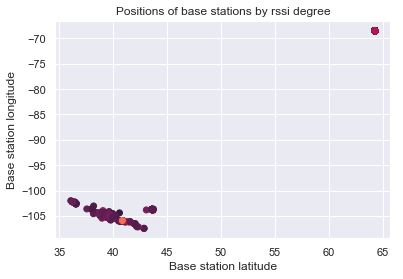

In [1933]:
# explore data : for each message, display corresponding bases
plt.scatter(df_mess_train['bs_lat'], df_mess_train['bs_lng'], c = df_mess_train['rssi'])
plt.title("Positions of base stations by rssi degree")
plt.xlabel("Base station latitude")
plt.ylabel("Base station longitude")
plt.show()

We found out that some base stations are located in a remote area compared to the rest of base stations.

Let's explore and see if those base stations are located nearby or far from the device.

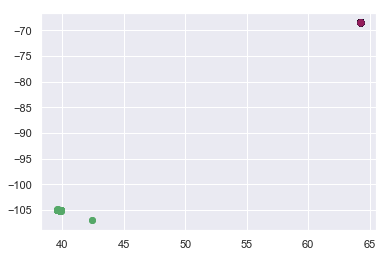

In [1934]:
idx = df_train.index[df_train['bs_lat'] > 60].tolist()
df_outliner_60 = df_train.loc[idx]
plt.scatter(df_outliner_60['bs_lat'], df_outliner_60['bs_lng'], c = df_outliner_60['rssi'])
plt.plot(df_outliner_60['lat'], df_outliner_60['lng'], 'go')
plt.show()

From this graph, we see that the devices are far awary from the base stations they send messages to.

In [1935]:
print("We discovered ", len(df_outliner_60['bsid'].unique()),\
      " base stations located far from the corresponding",\
     len(df_outliner_60['did'].unique()), " devices")

We discovered  27  base stations located far from the corresponding 49  devices


We decide to adjust base stations locations to have more accurate values, based on the rssi values they have for a certain device

In [8]:
# Get the messages corresponding to these 
idx = df_train.index[df_train['bs_lat'] > 60].tolist()
message_outliner_60 =  df_train.loc[idx,'messid'].unique()
# for each message, adjust the value of base lat and lng to nearest base stations by rssi value
for msg in message_outliner_60:    
    df_bymessage = df_train[df_train['messid'] == msg]
    
    index = df_bymessage.index[df_bymessage['bs_lat'] > 60].tolist()
    for idx in index:
    # We take the mean of the 3 nearest values
        value = df_bymessage.loc[idx,'rssi']
        tocompare = df_bymessage.iloc[(df_bymessage['rssi'] - value).abs().argsort()[1:4:]]#
        index_tocompare = tocompare.index[ tocompare['bs_lat'] < 60].tolist()
        
        if (len(index_tocompare)) > 0:
            v_lat = tocompare.loc[index_tocompare, 'bs_lat'].mean()        
            v_lng = tocompare.loc[index_tocompare, 'bs_lng'].mean()
            df_train.loc[idx,'bs_lat'] = v_lat
            df_train.loc[idx, 'bs_lng'] = v_lng
        else:
            df_train = df_train.drop(idx)
           


Let's see now if adjusting these value affected our data set 

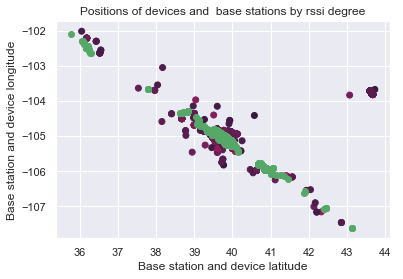

In [18]:
plt.scatter(df_train['bs_lat'], df_train['bs_lng'], c = df_train['rssi'])
plt.plot(df_train['lat'], df_train['lng'], 'go')
plt.title("Positions of devices and  base stations by rssi degree")
plt.xlabel("Base station and device latitude")
plt.ylabel("Base station and device longitude")
plt.show()

** Conclusion : **
After adjusting the values of base stations positions, we still notice that some base stations are located far from the devices. This potential outliner need to be explored in the following part.

#### Explore the outliners: part 2

We see in the last figure that there are some base stations that are far away from the line of devices.

Let's  focus on the devices they are receiving messages from.

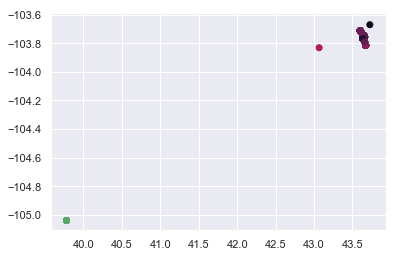

In [19]:
idx = df_train.index[df_train['bs_lat'] > 43].tolist()
df_outliner_43 = df_train.loc[idx]
plt.scatter(df_outliner_43['bs_lat'], df_outliner_43['bs_lng'], c = df_outliner_43['rssi'])
plt.plot(df_outliner_43['lat'], df_outliner_43['lng'], 'go')
plt.show()
## --> position of device false

In [20]:
print("We discovered", len(df_outliner_43['bsid'].unique()),\
       "base stations located far from the corresponding",\
     len(df_outliner_43['did'].unique()), "device")

We discovered 10 base stations located far from the corresponding 1 device


In [21]:
device_43 = df_outliner_43['did'].unique()[0]
base_stations_corresponding = df_train[df_train['did'] == device_43]["bsid"].unique()
print("There are", len(base_stations_corresponding), "sending messages to this device")

There are 44 sending messages to this device


In this case, we have to adjust the positions of the far away base stations

In [22]:
diff = set(base_stations_corresponding) - set(df_outliner_43['bsid'].unique())
idx1 = df_train.index[np.isin(df_train['bsid'],np.array(base_stations_corresponding))].tolist()
idx2 = df_train.index[df_train['did'] == device_43].tolist()
idx = set(idx1).intersection(set(idx2))
message_outliner_43 =  df_train.loc[idx,'messid'].unique()


In [23]:
# for each message, adjust the value of base lat and lng to nearest base stations by rssi value
for msg in message_outliner_43:    
    df_bymessage = df_train[df_train['messid'] == msg]
    
    index = df_bymessage.index[df_bymessage['bs_lat'] > 43].tolist()
    
    for idx in index:
    # We take the mean of the 3 nearest values
        value = df_bymessage.loc[idx,'rssi']
        tocompare = df_bymessage.iloc[(df_bymessage['rssi'] - value).abs().argsort()[1:4:]]
        index_tocompare = tocompare.index[ tocompare['bs_lat'] < 43].tolist()
        if (len(index_tocompare)) > 0:
            v_lat = tocompare.loc[index_tocompare, 'bs_lat'].mean()
            v_lng = tocompare.loc[index_tocompare,'bs_lng'].mean()
            df_train.loc[idx,'bs_lat'] = v_lat
            df_train.loc[idx, 'bs_lng'] = v_lng
        else:
            df_train = df_train.drop(idx)

In [24]:
data = df_train.groupby("messid").count()["bsid"]
data_with_3_pos = data[data>=3].count()
data_with_3_pos_less = data[data<3].count()

print("Messages sent to 3 base stations or more :", (data_with_3_pos / data.count() * 100), "%")
print("Messages sent to less than 3 stations: ", (data_with_3_pos_less / data.count() * 100), "%")

Messages sent to 3 base stations or more : 63.833049403747864 %
Messages sent to less than 3 stations:  36.16695059625213 %


Let's see how the base stations and devices are located now.

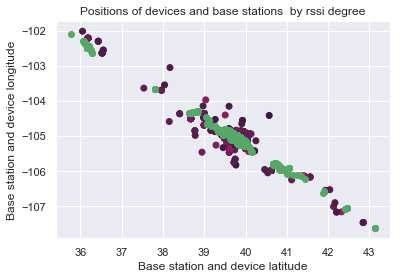

In [25]:
plt.scatter(df_train['bs_lat'], df_train['bs_lng'], c = df_train['rssi'])
plt.plot(df_train['lat'], df_train['lng'], 'go')
plt.title("Positions of devices and base stations  by rssi degree")
plt.xlabel("Base station and device latitude")
plt.ylabel("Base station and device longitude")
plt.show()

** Conclusion : **
After adjusting the values of base stations localization, the localisation of base stations and devices are more accurate as they are more close by.

#### Explore the distance

In our dataset, we have the RSSI information which corresponds to the Received Signal Strength Indication. It is the power of the signal received by the base stations.

There is a relation between the RSSI and the distance between the base station and the device.
RSSI = Ptx - 10 * n * log10(d) with:
- Ptx : Transmitter power of the base station (in dBm)
- n : The path loss exponent
- d : The distance

In Sigfox documentation (https://www.ismac-nc.net/wp/wp-content/uploads/2017/08/sigfoxtechnicaloverviewjuly2017-170802084218.pdf) :
The Ptx corresponds to a value of 22, whereas the n correpsonds to a value of 6

Another way to compute the distance between 2 objects given their latitude and longitute values is using the vincenty library

Let's explore in our dataset the distance computation and how accurate the rssi values are.

C:\Users\hmann\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


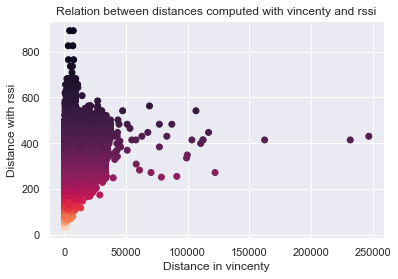

In [26]:
Ptx =  22
n = 6

d_vincenty = Eval_geoloc(df_train['bs_lat'] , df_train['bs_lng'], df_train['lat'], df_train['lng'])
plt.scatter(d_vincenty, 10 ** (((Ptx - df_train['rssi'])) / (10 * n)), c = df_train['rssi'])
plt.xlabel("Distance in vincenty")
plt.ylabel("Distance with rssi")
plt.title("Relation between distances computed with vincenty and rssi")
plt.show()

We expect to find a linear relation between the two distances computed

In [27]:
d_vincenty = np.array(d_vincenty).reshape(-1,1)
d_rssi = np.array(10 ** (((Ptx - df_train['rssi'])) / (10 * n)))
reg = lm.LinearRegression().fit( d_vincenty, d_rssi)

pente = reg.coef_[0]
print("pente = ", pente)
intercept= reg.intercept_
print("intercept = ", intercept)

pente =  0.004423331446088364
intercept =  283.1527365064734


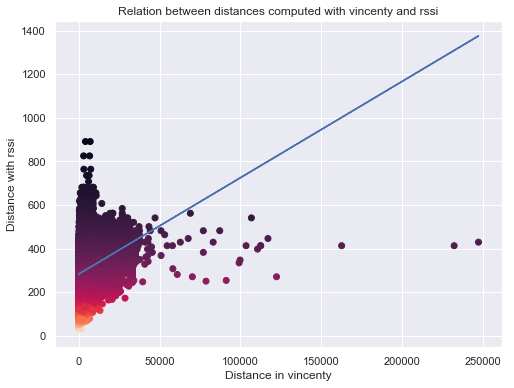

In [28]:
fig = plt.figure(figsize = (8,6))

plt.plot(d_vincenty, intercept + pente * d_vincenty)
plt.scatter(d_vincenty, d_rssi, c = df_train['rssi'])
plt.xlabel("Distance in vincenty")
plt.ylabel("Distance with rssi")
plt.title("Relation between distances computed with vincenty and rssi")
plt.show()

We found that there are some outliners values from 50000 in vincenty distance:

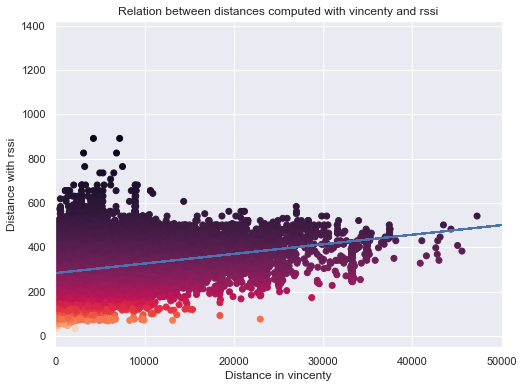

In [1965]:
fig = plt.figure(figsize = (8,6))

plt.plot(d_vincenty, intercept + pente * d_vincenty)
plt.scatter(d_vincenty, d_rssi, c = df_train['rssi'])
plt.xlim(0, 50000)
plt.xlabel("Distance in vincenty")
plt.ylabel("Distance with rssi")
plt.title("Relation between distances computed with vincenty and rssi")
plt.show()

In this case, we focus on latitude and longitude values of base stations for these points and adjust them.

In [29]:
df_train['d_vincenty'] = Eval_geoloc(df_train['bs_lat'] , df_train['bs_lng'], df_train['lat'], df_train['lng'])
idx = df_train.index[df_train['d_vincenty'] > 50000]

message_outliner_rssi =  df_train.loc[idx,'messid'].unique()
# for each message, adjust the value of base lat and lng to nearest base stations by rssi value
for msg in message_outliner_rssi:    
    df_bymessage = df_train[df_train['messid'] == msg]
    index = df_bymessage.index[df_bymessage['d_vincenty']  > 50000].tolist()
    for idx in index:
        value = df_bymessage.loc[idx,'rssi']
     # We take the mean of the 3 nearest values
        tocompare = df_bymessage.iloc[(df_bymessage['rssi'] - value).abs().argsort()[1::]]
        index_tocompare = tocompare.index[tocompare['d_vincenty'] < 50000].tolist()
        if (len(index_tocompare)) > 0:
            v_lat = tocompare.loc[index_tocompare, 'bs_lat'].mean()
            v_lng = tocompare.loc[index_tocompare, 'bs_lng'].mean()
            df_train.loc[idx,'bs_lat'] = v_lat
            df_train.loc[idx, 'bs_lng'] = v_lng
        else:
            df_train = df_train.drop(idx)

C:\Users\hmann\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


Now, let's see how readjusting these values impacted the distribution of base station and devices distances.

C:\Users\hmann\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


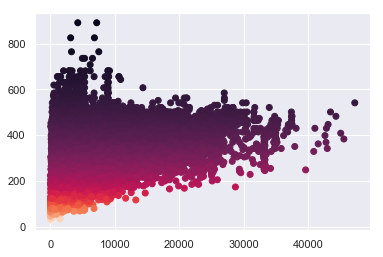

In [30]:
import math
Ptx =  22
n = 6

d_vincenty = Eval_geoloc(df_train['bs_lat'] , df_train['bs_lng'], df_train['lat'], df_train['lng'])
plt.scatter(d_vincenty, 10 ** (((Ptx - df_train['rssi'])) / (10 * n)), c = df_train['rssi'])
plt.show()

#### Feature engineering

In this section, we will focus on how to highlight the features of the model.

For that, we need some methods and information :

** List of base stations both in training and in test dataset **

In [6]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [7]:
len(listOfBs)

259

** Feature engineering based on base stations latitude and longitude **

In [8]:
def feature_engineering(df):
    df["rot45X"] = .707* df["bs_lng"] + .707* df["bs_lat"] 
    df["rot45Y"] = .707* df["bs_lng"] - .707* df["bs_lat"]

    df["rot30X"] = (1.732/2)* df["bs_lat"] + (1./2)* df["bs_lng"]
    df["rot30Y"] = (1.732/2)* df["bs_lng"] - (1./2)* df["bs_lat"]

    df["rot60X"] = (1./2)* df["bs_lat"] + (1.732/2)* df["bs_lng"] 
    df["rot60Y"] = (1./2)* df["bs_lng"] - (1.732/2)* df["bs_lat"]

    df["radial_r"] = np.sqrt( np.power(df["bs_lng"],2) + np.power(df["bs_lat"],2) )

Now, we try to build a feature matrix based on:

- Feature engineering of information of base station latitude and longitude
- Fingerprint method based on RSSI values by message
- The distance between a device and a base station  based on RSSI values
- The nseq values rounded 

In [9]:
# Feature Matrix construction 
def apply_on_array(a, word):
    add = lambda t: str(t) + word
    add_func = np.vectorize(add)
    result = add_func(a)
    return result

def feat_mat_const(df_mess_train, listOfBs):
    
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
        
    rssi = apply_on_array(listOfBs, '_rssi')    
    # Initialize the dataframe by -200 values for RSSI matrix
    df_feat = pd.DataFrame(data = -200, index=np.arange(nb_mess) ,columns = rssi) # feature matrix
    idx = 0
    Ptx =  22
    n = 6
    # add the values of rssi for each message and within each base station
    for key, elmt in df_mess_bs_group:
        df_grouped = df_mess_bs_group.get_group(key)        
        column_bsid_rssi = apply_on_array(df_grouped['bsid'], '_rssi')
        df_feat.loc[idx, column_bsid_rssi] \
         =  df_grouped['rssi'].values 
        
        idx = idx + 1
    
    # Mean of time_ux by message
    df_feat['time_ux'] =df_mess_bs_group.mean()[['time_ux']]
    
    # Mean of base latitude by message
    df_feat['bs_lat'] = df_mess_bs_group.mean()[['bs_lat']]
    
    # Mean of base longitude by message
    df_feat['bs_lng'] = df_mess_bs_group.mean()[['bs_lng']]
    
    # Rounded mean of nseq by message
    df_feat['nseq'] = round(df_mess_bs_group.mean()[['nseq']])
    
    # Feature engineering of base station latitude and longitude
    feature_engineering(df_feat)
     
    # Distance based on RSSI mean
    RSSI = df_mess_bs_group.mean()[['rssi']]
    df_feat["d"] = 10 ** (((Ptx - RSSI)) / (10 * n))
   
    return df_feat


Now we apply the feature engineering on the training dataset

In [13]:
df_feat = feat_mat_const(df_train, listOfBs )

TypeError: a float is required

In [ ]:
df_feat.head()

We also get the output vectors for the true device positions 

In [37]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):
    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [38]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_train.iloc[:,:-3], df_train[['lat','lng']])

### Model construction

In this section, we build a model to train on the supervised data set.
We are using a machine learning algorithm based on AdaBoostRegressor with a random forest regressor.

The random forest algorithm is an algorithm easy to use and allows to tune randomized decision trees and take the average model.
The use of this algorithm can be risky as it can result in overfitting. That's why, to reduce overfitting, adaboost algorithm can be used as it adds weights into randomized decision trees, more weights to good regressors and less weight for the others.

In [49]:
# Function for training and prediction
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng
    from sklearn import linear_model
    from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
    from sklearn.ensemble import AdaBoostRegressor
    X_train = np.array(df_feat);
    reg = AdaBoostRegressor(RandomForestRegressor(),
                            n_estimators=1000)
    reg.fit(X_train, ground_truth_lat);
    y_pred_lat = reg.predict(df_test) 

    reg.fit(X_train, ground_truth_lng);
    y_pred_lng = reg.predict(df_test) 
    
    return y_pred_lat, y_pred_lng, reg



#### Apply the model on training dataset

We start by evaluating the model on all the training data set provided.

In [1987]:
# Make regressor and prediction using the train set
y_pred_lat, y_pred_lng, reg = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat)

Explore the importance of the features in our feature matrix.

In [1995]:
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df_feat.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, df_feat.columns[int(indices[f])], importances[indices[f]]))

Feature ranking:
1. feature rot30X (0.143117)
2. feature bs_lat (0.140948)
3. feature radial_r (0.139315)
4. feature rot60Y (0.136732)
5. feature bs_lng (0.123115)
6. feature rot45Y (0.120916)
7. feature rot30Y (0.115249)
8. feature rot60X (0.065078)
9. feature time_ux (0.004645)
10. feature rot45X (0.003143)
11. feature d (0.001674)
12. feature 1828_rssi (0.000323)
13. feature 4790_rssi (0.000298)
14. feature 3629_rssi (0.000270)
15. feature nseq (0.000264)
16. feature 1872_rssi (0.000207)
17. feature 3613_rssi (0.000190)
18. feature 4024_rssi (0.000172)
19. feature 8473_rssi (0.000168)
20. feature 980_rssi (0.000166)
21. feature 4058_rssi (0.000155)
22. feature 8245_rssi (0.000149)
23. feature 1859_rssi (0.000141)
24. feature 2610_rssi (0.000134)
25. feature 1012_rssi (0.000110)
26. feature 7382_rssi (0.000109)
27. feature 2737_rssi (0.000105)
28. feature 1878_rssi (0.000097)
29. feature 3526_rssi (0.000096)
30. feature 3562_rssi (0.000095)
31. feature 1476_rssi (0.000094)
32. featur

Let's now evaluate the precision of this model based only on the training set.

In [2001]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)
# Error criterion
print("The precision on the training set is ", np.percentile(err_vec, 80))

C:\Users\hmann\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


The precision on the training set is  652.5737025145686


We get a good estimation up to 600 meters

#### Cross validation of the model

In [136]:
# Cross validation

In [2102]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
reg = AdaBoostRegressor(RandomForestRegressor(),
                            n_estimators=1000)#
y_pred_lng = cross_val_predict(reg, df_feat, ground_truth_lng, cv=10)
y_pred_lat = cross_val_predict(reg, df_feat, ground_truth_lat, cv=10)

Let's now evaluate the error, on the cross validation

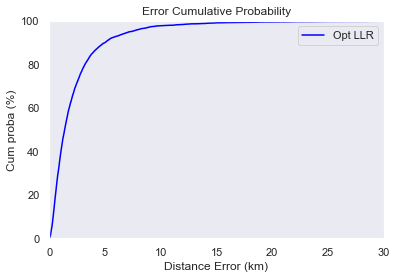

In [2106]:
# Plot error distribution
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

In [2107]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)
# Error criterion
print("The precision with cross validation on the training set is ", np.percentile(err_vec, 80))

The precision with cross validation on the training set is  3224.5836482054124


C:\Users\hmann\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


We have predicted with cross validation with a precision error of  3,2km

### Construct test prediction

#### Data exploration

In [40]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


We count the number of messages sent to 3 or more station bases.

In [41]:
data = df_mess_test.groupby("messid").count()["bsid"]
data_with_3_pos = data[data>=3].count()
data_with_3_pos_less = data[data<3].count()

print("Messages sent to 3 base stations or more :" ,(data_with_3_pos / data.count() * 100), "%")
print("Messages sent to less than 3 stations : ", (data_with_3_pos_less / data.count() * 100), "%")

Messages sent to 3 base stations or more : 60.540234227427284 %
Messages sent to less than 3 stations :  39.45976577257272 %


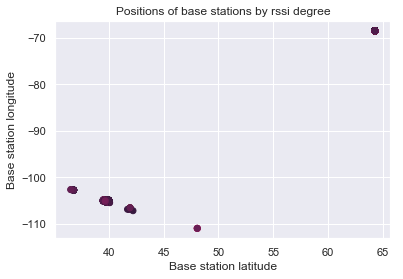

In [42]:
# explore data : for each message, display corresponding bases
plt.scatter(df_mess_test['bs_lat'], df_mess_test['bs_lng'], c = df_mess_test['rssi'])
plt.title("Positions of base stations by rssi degree")
plt.xlabel("Base station latitude")
plt.ylabel("Base station longitude")
plt.show()

We notice that there are some base stations  located very far from other base stations. Let's explore their positions and if they correspond to base stations already dealt with in the training dataset.

In [43]:
idx_60_train = df_mess_train.index[df_mess_train['bs_lat'] > 60].tolist()
base_stations_60_train = df_mess_train.loc[idx_60_train, 'bsid']

idx_60_test = df_mess_test.index[df_mess_test['bs_lat'] > 60].tolist()
base_stations_60_test = df_mess_test.loc[idx_60_test, 'bsid']

bases_to_correct = set(base_stations_60_train) & set(base_stations_60_test)
indexes_to_correct = df_mess_test.index[df_mess_test['bsid'].isin(bases_to_correct)].tolist()

bases_outliner_60 =  df_mess_test.loc[indexes_to_correct,'bsid'].unique()
# for each message, adjust the value of base lat and lng to nearest base stations by rssi value
for base in bases_outliner_60:    
    correct_value = df_train[df_train['bsid'] == base]
    false_values_indexes = df_mess_test.index[df_mess_test['bsid'] == base].tolist()
    for idx in false_values_indexes:
        df_mess_test.loc[idx,'bs_lat'] = correct_value['bs_lat'].mean()
        df_mess_test.loc[idx,'bs_lng'] = correct_value['bs_lng'].mean()
    

Let's see how readjusting these values modified the locations of base stations.

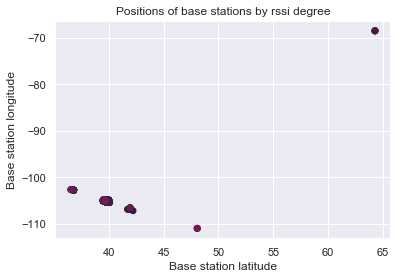

In [44]:
# explore data : for each message, display corresponding bases
plt.scatter(df_mess_test['bs_lat'], df_mess_test['bs_lng'], c = df_mess_test['rssi'])
plt.title("Positions of base stations by rssi degree")
plt.xlabel("Base station latitude")
plt.ylabel("Base station longitude")
plt.show()

Some base stations are still very far from the others. Let's see how many and how many messages there are sent to them.

In [45]:
idx_60_test = df_mess_test.index[df_mess_test['bs_lat'] > 60].tolist()
base_stations_60_test = df_mess_test.loc[idx_60_test, 'bsid']

print('There are ', len(set(base_stations_60_test)), 'left and ',\
      len(set(idx_60_test)), 'messages sent to them')

There are  2 left and  5 messages sent to them


We leave these 5 messages for now.

#### Feature engineering and prediction on test dataset

In [46]:
# Feature engineering
df_feat_test = feat_mat_const(df_mess_test, listOfBs)

In [47]:
df_feat_test.head()

,879_rssi,911_rssi,921_rssi,944_rssi,980_rssi,1012_rssi,1086_rssi,1092_rssi,1120_rssi,1131_rssi,...,bs_lng,nseq,rot45X,rot45Y,rot30X,rot30Y,rot60X,rot60Y,radial_r,d
0,-200,-200,-200,-200,-200,-200.0,-200.0,-200.0,-200,-200.0,...,-105.163032,2.0,-46.262107,-102.438420,-18.176504,-110.935511,-71.206860,-86.986528,112.417209,164.689787
1,-200,-200,-200,-200,-200,-200.0,-200.0,-200.0,-200,-200.0,...,-105.094321,0.0,-46.188908,-102.414461,-18.111992,-110.893419,-71.129945,-86.982329,112.365253,294.272718
2,-200,-200,-200,-200,-200,-200.0,-200.0,-200.0,-200,-200.0,...,-105.028319,2.0,-46.210932,-102.299111,-18.163124,-110.787685,-71.121363,-86.865195,112.269163,319.276289
3,-200,-200,-200,-200,-200,-200.0,-200.0,-200.0,-200,-200.0,...,-105.072701,1.0,-46.160446,-102.412353,-18.085041,-110.884015,-71.101903,-86.987660,112.351631,177.827941
4,-200,-200,-200,-200,-200,-200.0,-200.0,-200.0,-200,-200.0,...,-105.028319,1.0,-46.210932,-102.299111,-18.163124,-110.787685,-71.121363,-86.865195,112.269163,331.237035


In [52]:
y_pred_lat, y_pred_lng, reg = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res.to_csv('pred_pos_test_list_adaBoost.csv', index=False)

In [53]:
test_res.head()

,lat,lng
0,39.731561,-105.106439
1,39.781938,-105.084045
2,39.680932,-105.003553
3,39.780816,-105.082509
4,39.682043,-105.001230
